In [1]:
#import the relevant liabaries

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
from sklearn import cluster
import matplotlib.pyplot as plt
import numpy as np
import pysal
from pysal.lib import weights
from pysal.explore import esda
from esda.moran import Moran,Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster
import seaborn as sns

In [2]:
#loading the airbnb_vienna_csv file from the local desktop
vienna_airbnb = pd.read_csv('/Users/michael/Desktop/tomslee_airbnb_vienna_0123_2015-07-24_new.csv',sep=';')

In [3]:
#printing the first 5 rows
vienna_airbnb.head()

,room_id,host_id,room_type,district,district-name,neighbourhood_group,reviews,review_scores_rating,review_scores_overall_satisfaction,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,accommodates,bedrooms,price,minstay,latitude,longitude
0,278286,1452720,Private room,9,Alsergrund,905,48,2.2,4.8,4.2,4.4,4.7,4.9,4.3,2.0,1.0,59,3.0,48.224326,16.357004
1,546999,2074463,Private room,9,Alsergrund,902,7,2.2,4.3,3.0,4.9,4.0,4.5,4.2,2.0,1.0,37,3.0,48.223503,16.365201
2,5514700,22072627,Private room,9,Alsergrund,904,5,4.9,4.4,4.5,4.5,4.4,3.6,4.3,2.0,1.0,51,2.0,48.226394,16.353791
3,6527073,34136313,Private room,9,Alsergrund,904,3,2.9,4.8,2.5,4.2,4.2,4.0,4.9,2.0,1.0,33,1.0,48.226342,16.350905
4,7154476,37468348,Private room,9,Alsergrund,905,4,2.9,3.8,3.0,4.6,3.8,4.3,4.6,2.0,1.0,29,1.0,48.219313,16.358975


In [4]:
#creating a point geometry from the longitude and latitude columns
geometry = [Point(xy) for xy in zip(vienna_airbnb['longitude'], vienna_airbnb['latitude'])]
# initialize the coordinate reference system EPSG:4326
crs = {'init': 'epsg:4326'}
#creating the geopandas Geodataframe 
vienna_gdf = gpd.GeoDataFrame(vienna_airbnb, crs=crs, geometry=geometry)

/opt/anaconda3/envs/savi/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
#Print the last 5 rows
vienna_gdf.tail()

,room_id,host_id,room_type,district,district-name,neighbourhood_group,reviews,review_scores_rating,review_scores_overall_satisfaction,review_scores_accuracy,...,review_scores_checkin,review_scores_communication,review_scores_location,accommodates,bedrooms,price,minstay,latitude,longitude,geometry
5337,3092333,9800003,Entire home/apt,23,Liesing,2306,0,2.4,4.2,3.8,...,3.9,4.2,4.7,3.0,3.0,87,1.0,48.13660,16.28990,POINT (16.28990 48.13660)
5338,100023,2300124,Entire home/apt,23,Liesing,2306,2,3.0,4.9,4.2,...,4.8,3.6,1.9,1.0,1.0,72,1.0,48.13180,16.30770,POINT (16.30770 48.13180)
5339,4000234,500023,Entire home/apt,11,Simmering,1108,6,3.4,3.6,4.6,...,3.9,4.4,3.4,1.0,3.0,44,1.0,48.17566,16.42834,POINT (16.42834 48.17566)
5340,4500032,4350003,Entire home/apt,11,Simmering,1108,3,4.3,4.8,2.5,...,4.5,4.7,3.1,2.0,3.0,31,2.0,48.18342,16.43819,POINT (16.43819 48.18342)
5341,394235,352353,Private room,11,Simmering,1108,13,3.3,4.1,2.6,...,4.3,4.9,2.0,1.0,2.0,29,3.0,48.17719,16.44017,POINT (16.44017 48.17719)


In [6]:
#creating a shapefile on the deskotp with our new geodataframe
vienna_gdf.to_file('/Users/michael/Desktop/Airbnb_Vienna.shp', driver='ESRI Shapefile')

In [7]:
#Grouping a second dataframe with the neighbourhood group and calculating the mean price for all neighbourhoods
a = vienna_gdf 
a1 = a.groupby('neighbourhood_group')
a2 = a1['price'].mean()
a2

neighbourhood_group
101     121.175000
102     163.190476
103     179.416667
104     194.941176
105     127.344828
           ...    
2315     96.000000
2316     56.000000
2317     47.000000
2318     72.000000
2319     56.000000
Name: price, Length: 248, dtype: float64

In [8]:
#Grouping a second dataframe with the neighbourhood group and calculating the median price for all neighbourhoods
b = vienna_gdf 
b1 = b.groupby('neighbourhood_group')
b2 = b1['price'].median()
b2

neighbourhood_group
101     112.0
102     113.0
103     141.5
104     112.0
105     112.0
        ...  
2315     96.0
2316     56.0
2317     47.0
2318     72.0
2319     56.0
Name: price, Length: 248, dtype: float64

In [9]:
#Merging the two grouped dataframes with the vienna_gdf 
vienna_gdf = vienna_gdf.merge(a2, left_on='neighbourhood_group', right_on='neighbourhood_group')
vienna_gdf = vienna_gdf.merge(b2, left_on='neighbourhood_group', right_on='neighbourhood_group')

In [10]:
#Showing the merged dataframe (price_x for median price/price_y for average price)
vienna_gdf.head()

,room_id,host_id,room_type,district,district-name,neighbourhood_group,reviews,review_scores_rating,review_scores_overall_satisfaction,review_scores_accuracy,...,review_scores_location,accommodates,bedrooms,price_x,minstay,latitude,longitude,geometry,price_y,price
0,278286,1452720,Private room,9,Alsergrund,905,48,2.2,4.8,4.2,...,4.3,2.0,1.0,59,3.0,48.224326,16.357004,POINT (16.35700 48.22433),73.678571,57.5
1,7154476,37468348,Private room,9,Alsergrund,905,4,2.9,3.8,3.0,...,4.6,2.0,1.0,29,1.0,48.219313,16.358975,POINT (16.35898 48.21931),73.678571,57.5
2,1502484,8031874,Private room,9,Alsergrund,905,47,5.0,4.7,4.4,...,4.3,2.0,1.0,59,2.0,48.218794,16.361072,POINT (16.36107 48.21879),73.678571,57.5
3,3871678,8031874,Private room,9,Alsergrund,905,65,5.0,3.5,3.5,...,4.2,2.0,1.0,55,2.0,48.218163,16.360208,POINT (16.36021 48.21816),73.678571,57.5
4,6419039,4759856,Private room,9,Alsergrund,905,4,3.2,4.8,4.7,...,4.9,2.0,1.0,32,1.0,48.219656,16.356964,POINT (16.35696 48.21966),73.678571,57.5


In [11]:
#Rename columns price_x as median price for the neighbourhood group, price_y as average price for the neighbourhood group 
vienna_gdf.rename(
    columns={'price_x':'median_price_neighb_group'},
    inplace=True
)


vienna_gdf.rename(
  columns={'price_y' : 'avg_price_neighb_group'},
  inplace=True
)


In [12]:
#Quick data types check 
vienna_gdf.dtypes

room_id                                  int64
host_id                                  int64
room_type                               object
district                                 int64
district-name                           object
neighbourhood_group                      int64
reviews                                  int64
review_scores_rating                   float64
review_scores_overall_satisfaction     float64
review_scores_accuracy                 float64
review_scores_cleanliness              float64
review_scores_checkin                  float64
review_scores_communication            float64
review_scores_location                 float64
accommodates                           float64
bedrooms                               float64
median_price_neighb_group                int64
minstay                                float64
latitude                               float64
longitude                              float64
geometry                              geometry
avg_price_nei

In [13]:
#Grouping again for the districts to get the median and average price
a3 = vienna_gdf.groupby('district')
a4 = a3['price'].mean()
a5 = a3['price'].median()

In [14]:
a4

district
1     122.462898
2      69.035533
3      71.840426
4      68.681979
5      63.854795
6      71.274448
7      70.291284
8      67.062802
9      62.622283
10     67.577114
11     48.000000
12     60.471831
13     65.844156
14     62.285714
15     62.654434
16     56.060748
17     52.953757
18     56.893855
19     62.552000
20     65.946237
21     68.986486
22     58.893130
23     74.708333
Name: price, dtype: float64

In [15]:
#Merging the two grouped dataframes with the vienna_gdf 
vienna_gdf = vienna_gdf.merge(a4, left_on='district', right_on='district')
vienna_gdf = vienna_gdf.merge(a5, left_on='district', right_on='district')

In [16]:
vienna_gdf

,room_id,host_id,room_type,district,district-name,neighbourhood_group,reviews,review_scores_rating,review_scores_overall_satisfaction,review_scores_accuracy,...,bedrooms,median_price_neighb_group,minstay,latitude,longitude,geometry,avg_price_neighb_group,price_x,price_y,price
0,278286,1452720,Private room,9,Alsergrund,905,48,2.2,4.8,4.2,...,1.0,59,3.0,48.224326,16.357004,POINT (16.35700 48.22433),73.678571,57.5,62.622283,57.5
1,7154476,37468348,Private room,9,Alsergrund,905,4,2.9,3.8,3.0,...,1.0,29,1.0,48.219313,16.358975,POINT (16.35898 48.21931),73.678571,57.5,62.622283,57.5
2,1502484,8031874,Private room,9,Alsergrund,905,47,5.0,4.7,4.4,...,1.0,59,2.0,48.218794,16.361072,POINT (16.36107 48.21879),73.678571,57.5,62.622283,57.5
3,3871678,8031874,Private room,9,Alsergrund,905,65,5.0,3.5,3.5,...,1.0,55,2.0,48.218163,16.360208,POINT (16.36021 48.21816),73.678571,57.5,62.622283,57.5
4,6419039,4759856,Private room,9,Alsergrund,905,4,3.2,4.8,4.7,...,1.0,32,1.0,48.219656,16.356964,POINT (16.35696 48.21966),73.678571,57.5,62.622283,57.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5337,66435,90834,Entire home/apt,11,Simmering,1112,27,2.4,3.5,4.7,...,2.0,39,3.0,48.168920,16.479860,POINT (16.47986 48.16892),63.500000,63.5,48.000000,42.5
5338,8097431,8274114,Entire home/apt,11,Simmering,1112,0,3.5,3.5,4.1,...,8.0,88,1.0,48.165260,16.497050,POINT (16.49705 48.16526),63.500000,63.5,48.000000,42.5
5339,4000234,500023,Entire home/apt,11,Simmering,1108,6,3.4,3.6,4.6,...,3.0,44,1.0,48.175660,16.428340,POINT (16.42834 48.17566),34.666667,31.0,48.000000,42.5
5340,4500032,4350003,Entire home/apt,11,Simmering,1108,3,4.3,4.8,2.5,...,3.0,31,2.0,48.183420,16.438190,POINT (16.43819 48.18342),34.666667,31.0,48.000000,42.5


In [17]:
#Rename columns price_x as median price for the district, price_y as average price for the district
vienna_gdf.rename(
  columns={'price_x' : 'median_price_district'},
  inplace=True
)

vienna_gdf.rename(
  columns={'price_y' : 'avg_price_district'},
  inplace=True
)

In [18]:
vienna_gdf

,room_id,host_id,room_type,district,district-name,neighbourhood_group,reviews,review_scores_rating,review_scores_overall_satisfaction,review_scores_accuracy,...,bedrooms,median_price_neighb_group,minstay,latitude,longitude,geometry,avg_price_neighb_group,median_price_district,avg_price_district,price
0,278286,1452720,Private room,9,Alsergrund,905,48,2.2,4.8,4.2,...,1.0,59,3.0,48.224326,16.357004,POINT (16.35700 48.22433),73.678571,57.5,62.622283,57.5
1,7154476,37468348,Private room,9,Alsergrund,905,4,2.9,3.8,3.0,...,1.0,29,1.0,48.219313,16.358975,POINT (16.35898 48.21931),73.678571,57.5,62.622283,57.5
2,1502484,8031874,Private room,9,Alsergrund,905,47,5.0,4.7,4.4,...,1.0,59,2.0,48.218794,16.361072,POINT (16.36107 48.21879),73.678571,57.5,62.622283,57.5
3,3871678,8031874,Private room,9,Alsergrund,905,65,5.0,3.5,3.5,...,1.0,55,2.0,48.218163,16.360208,POINT (16.36021 48.21816),73.678571,57.5,62.622283,57.5
4,6419039,4759856,Private room,9,Alsergrund,905,4,3.2,4.8,4.7,...,1.0,32,1.0,48.219656,16.356964,POINT (16.35696 48.21966),73.678571,57.5,62.622283,57.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5337,66435,90834,Entire home/apt,11,Simmering,1112,27,2.4,3.5,4.7,...,2.0,39,3.0,48.168920,16.479860,POINT (16.47986 48.16892),63.500000,63.5,48.000000,42.5
5338,8097431,8274114,Entire home/apt,11,Simmering,1112,0,3.5,3.5,4.1,...,8.0,88,1.0,48.165260,16.497050,POINT (16.49705 48.16526),63.500000,63.5,48.000000,42.5
5339,4000234,500023,Entire home/apt,11,Simmering,1108,6,3.4,3.6,4.6,...,3.0,44,1.0,48.175660,16.428340,POINT (16.42834 48.17566),34.666667,31.0,48.000000,42.5
5340,4500032,4350003,Entire home/apt,11,Simmering,1108,3,4.3,4.8,2.5,...,3.0,31,2.0,48.183420,16.438190,POINT (16.43819 48.18342),34.666667,31.0,48.000000,42.5


In [19]:
#Read in Vienna districts shapefile
districts_gdf = gpd.read_file("/Users/michael/Desktop/Vienna.shp")

In [20]:
districts_gdf

,district-n,district,geometry
0,Leopoldstadt,2,"POLYGON ((16.38484 48.22616, 16.38495 48.22622..."
1,Landstrasse,3,"POLYGON ((16.38681 48.21271, 16.38683 48.21271..."
2,Innere Stadt,1,"POLYGON ((16.36497 48.21590, 16.36498 48.21590..."
3,Brigittenau,20,"POLYGON ((16.38595 48.24764, 16.38611 48.24748..."
4,Floridsdorf,21,"POLYGON ((16.37817 48.28858, 16.37819 48.28859..."
5,Donaustadt,22,"POLYGON ((16.48378 48.17615, 16.48358 48.17628..."
6,Liesing,23,"POLYGON ((16.33924 48.15405, 16.33948 48.15388..."
7,Alsergrund,9,"POLYGON ((16.34255 48.21837, 16.34259 48.21847..."
8,Penzing,14,"POLYGON ((16.27508 48.21508, 16.27512 48.21507..."
9,Mariahilf,6,"POLYGON ((16.34200 48.19634, 16.34424 48.19671..."


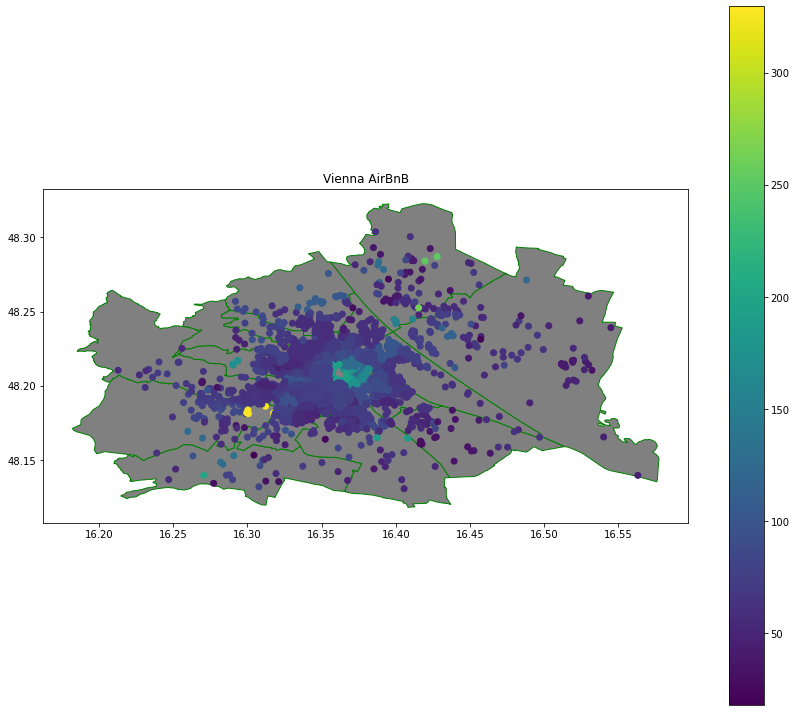

In [21]:
#Plotting the Vienna AirBnB prices and the districts geodataframe in the background
fig, ax = plt.subplots(figsize=(12,10))
districts_gdf.plot(ax=ax, facecolor='grey', edgecolor='green')
vienna_gdf.plot(column="avg_price_neighb_group", ax=ax, legend=True)

plt.title("Vienna AirBnB")
plt.tight_layout()
plt.show()


In [22]:
#Calculating Queen contiguity spatial weights (spatial leg standardize the rows and takes the average result of the price)
w = weights.Queen.from_dataframe(vienna_gdf, idVariable="room_id" )
w.transform = "R"
vienna_gdf["w_price"] = weights.lag_spatial(w, vienna_gdf["avg_price_neighb_group"])
vienna_gdf.head()

,room_id,host_id,room_type,district,district-name,neighbourhood_group,reviews,review_scores_rating,review_scores_overall_satisfaction,review_scores_accuracy,...,median_price_neighb_group,minstay,latitude,longitude,geometry,avg_price_neighb_group,median_price_district,avg_price_district,price,w_price
0,278286,1452720,Private room,9,Alsergrund,905,48,2.2,4.8,4.2,...,59,3.0,48.224326,16.357004,POINT (16.35700 48.22433),73.678571,57.5,62.622283,57.5,74.184658
1,7154476,37468348,Private room,9,Alsergrund,905,4,2.9,3.8,3.0,...,29,1.0,48.219313,16.358975,POINT (16.35898 48.21931),73.678571,57.5,62.622283,57.5,70.697952
2,1502484,8031874,Private room,9,Alsergrund,905,47,5.0,4.7,4.4,...,59,2.0,48.218794,16.361072,POINT (16.36107 48.21879),73.678571,57.5,62.622283,57.5,72.249125
3,3871678,8031874,Private room,9,Alsergrund,905,65,5.0,3.5,3.5,...,55,2.0,48.218163,16.360208,POINT (16.36021 48.21816),73.678571,57.5,62.622283,57.5,128.707038
4,6419039,4759856,Private room,9,Alsergrund,905,4,3.2,4.8,4.7,...,32,1.0,48.219656,16.356964,POINT (16.35696 48.21966),73.678571,57.5,62.622283,57.5,68.580401


In [23]:
#Calculating the global spatial autocorrelation to find the overall pattern in the dataset
y = vienna_gdf["avg_price_neighb_group"]
moran = Moran(y, w)
moran.I

0.013145239031757582

In [24]:
#check if the p-value of the global spatial autocorrelation is (reliable) significant p_value <= 0.05
moran.p_sim

0.056

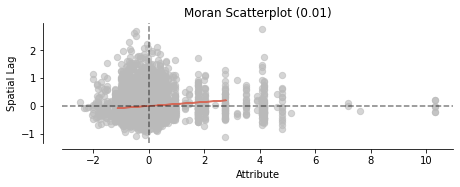

In [25]:
#Plotting Moran's I scatterplot to visualize the global spatial autocorrelation
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

In [26]:
m_local = Moran_Local(y, w)

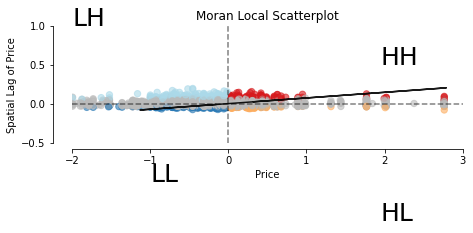

In [27]:
#Plotting the Moran Local Scatterplot 
fig, ax = moran_scatterplot(m_local, p=0.05)
ax.set_xlabel('Price')
ax.set_ylabel('Spatial Lag of Price')
plt.ylim((-0.5,1))
plt.xlim((-2,3))
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

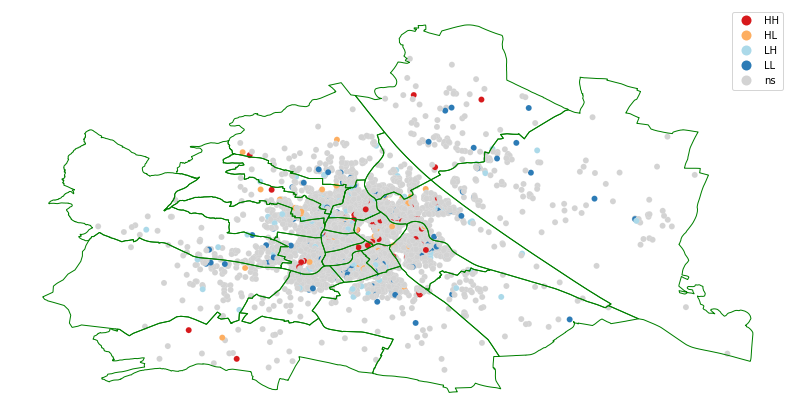

In [28]:
#plotting the LISA cluster 
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(m_local, vienna_gdf, p=0.05, figsize = (16,12),ax=ax)
districts_gdf.plot(ax=ax, facecolor='None', edgecolor='green')
plt.show()

In [29]:
#read in json file for the neighbourhood_group geometries
airbnb_vienna = gpd.read_file("/Users/michael/Desktop/ZAEHLBEZIRKOGD.json")

In [30]:
#Quick check of the coordinate reference system
airbnb_vienna.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
#using only the selected columns for the new geodataframe
airbnb_new = airbnb_vienna[['BEZNR','ZBEZ','geometry']]

In [32]:
#Renaming the columns
airbnb_new.rename(
  columns={'BEZNR' : 'district'},
  inplace=True
)

airbnb_new.rename(
  columns={'ZBEZ' : 'neighbourhood_group'},
  inplace=True
)

/opt/anaconda3/envs/savi/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [33]:
airbnb_new

,district,neighbourhood_group,geometry
0,21,2129,"POLYGON ((16.39317 48.28030, 16.39322 48.28032..."
1,21,2101,"POLYGON ((16.40456 48.30195, 16.40440 48.30084..."
2,14,1404,"POLYGON ((16.29923 48.19271, 16.29967 48.19269..."
3,10,1012,"POLYGON ((16.34805 48.16615, 16.34844 48.16676..."
4,21,2121,"POLYGON ((16.40342 48.26006, 16.40362 48.26015..."
...,...,...,...
245,22,2207,"POLYGON ((16.49017 48.25612, 16.49101 48.25743..."
246,22,2231,"POLYGON ((16.46116 48.22709, 16.46160 48.22770..."
247,20,2006,"POLYGON ((16.37046 48.23554, 16.37256 48.23570..."
248,10,1014,"POLYGON ((16.38276 48.14955, 16.38267 48.14986..."


In [34]:
#Creating a subset of the vienna geodataframe, which include all ratings, prices, neighbourhood_group and room_id (without the geometry)
vienna_gdf_2 = vienna_gdf[['neighbourhood_group','room_id','review_scores_rating','review_scores_overall_satisfaction','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','median_price_neighb_group','avg_price_neighb_group','median_price_district','avg_price_district', 'price', 'w_price']]

In [35]:
vienna_gdf_2

,neighbourhood_group,room_id,review_scores_rating,review_scores_overall_satisfaction,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,median_price_neighb_group,avg_price_neighb_group,median_price_district,avg_price_district,price,w_price
0,905,278286,2.2,4.8,4.2,4.4,4.7,4.9,4.3,59,73.678571,57.5,62.622283,57.5,74.184658
1,905,7154476,2.9,3.8,3.0,4.6,3.8,4.3,4.6,29,73.678571,57.5,62.622283,57.5,70.697952
2,905,1502484,5.0,4.7,4.4,4.5,4.1,4.6,4.3,59,73.678571,57.5,62.622283,57.5,72.249125
3,905,3871678,5.0,3.5,3.5,4.8,4.3,4.2,4.2,55,73.678571,57.5,62.622283,57.5,128.707038
4,905,6419039,3.2,4.8,4.7,5.0,3.7,4.8,4.9,32,73.678571,57.5,62.622283,57.5,68.580401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5337,1112,66435,2.4,3.5,4.7,4.3,3.6,4.8,4.4,39,63.500000,63.5,48.000000,42.5,71.114258
5338,1112,8097431,3.5,3.5,4.1,4.8,4.7,3.6,1.5,88,63.500000,63.5,48.000000,42.5,77.354785
5339,1108,4000234,3.4,3.6,4.6,4.2,3.9,4.4,3.4,44,34.666667,31.0,48.000000,42.5,70.005301
5340,1108,4500032,4.3,4.8,2.5,4.8,4.5,4.7,3.1,31,34.666667,31.0,48.000000,42.5,77.692297


In [36]:
#Changing the neighbourhood_group in the airbnb_new dataframe to the type integer that we can match the two dataframes
airbnb_new['neighbourhood_group']=airbnb_new['neighbourhood_group'].astype(int)

<ipython-input-36-2cbba555b7dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_new['neighbourhood_group']=airbnb_new['neighbourhood_group'].astype(int)


In [37]:
#checking the dtypes, the neighbourood_group type has changed from object to integer64
airbnb_new.dtypes

district                  int64
neighbourhood_group       int64
geometry               geometry
dtype: object

In [38]:
#Matching both dataframes
airbnb_neighb_gdf = airbnb_new.merge(vienna_gdf_2, left_on='neighbourhood_group', right_on='neighbourhood_group')

In [39]:
#checking the coordinate reference system
airbnb_neighb_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

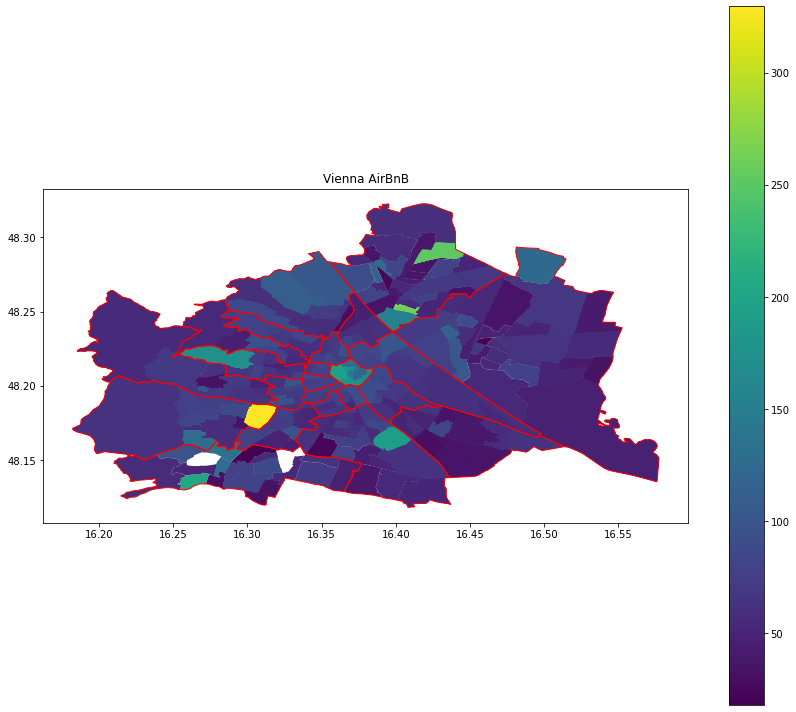

In [127]:
#Plotting the Vienna AirBnB prices and the districts geodataframe
fig, ax = plt.subplots(figsize=(12,10))
airbnb_neighb_gdf.plot(column="avg_price_neighb_group", ax=ax, legend=True)
districts_gdf.plot(ax=ax, facecolor='None', edgecolor='red')
plt.title("Vienna AirBnB")
plt.tight_layout()
plt.show()

In [41]:
#Calculating Queen contiguity spatial weights (spatial leg standardize the rows and takes the average result of the price)
w = weights.Queen.from_dataframe(airbnb_neighb_gdf, idVariable="room_id" )
w.transform = "R"
airbnb_neighb_gdf["w_price"] = weights.lag_spatial(w, airbnb_neighb_gdf["avg_price_neighb_group"])


In [42]:
#Calculating the global spatial autocorrelation to find the overall pattern in the dataset
y = airbnb_neighb_gdf["avg_price_neighb_group"]
moran = Moran(y, w)
moran.I

0.002222789620975046

In [43]:
#check if the p-value of the global spatial autocorrelation is (reliable) significant p_value 
moran.p_sim

0.073

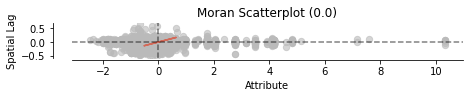

In [44]:
#Plotting Moran's I scatterplot to visualize the global spatial autocorrelation
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

In [45]:
#Calculating Morans Local Autocorrelation (LISA)
m_local = Moran_Local(y, w)

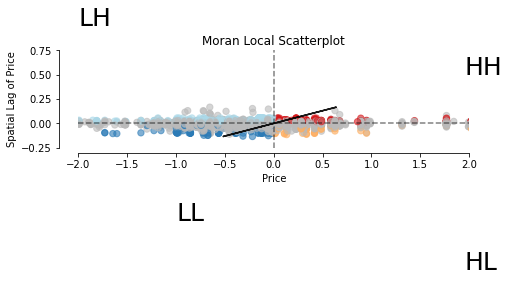

In [46]:
#Plotting the Moran Local Scatterplot 
fig, ax = moran_scatterplot(m_local, p=0.05)
ax.set_xlabel('Price')
ax.set_ylabel('Spatial Lag of Price')
plt.ylim((-0.25,0.75))
plt.xlim((-2,2))
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

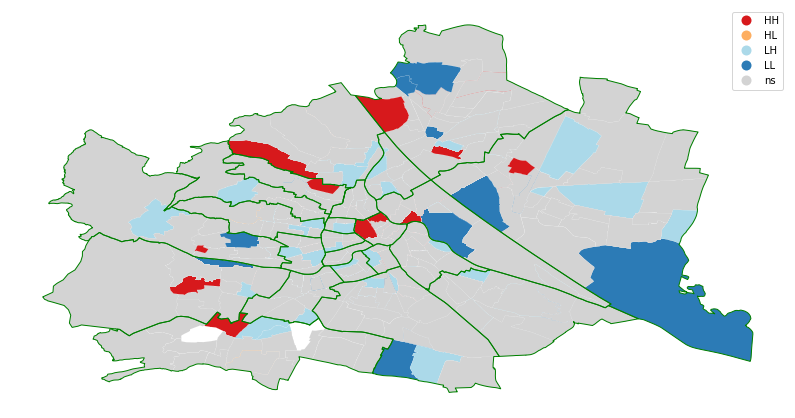

In [47]:
#Plotting the LISA cluster 
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(m_local, airbnb_neighb_gdf, p=0.05, figsize = (16,12),ax=ax)
districts_gdf.plot(ax=ax, facecolor='None', edgecolor='green')
plt.show()

In [48]:
#creating a rating list which helps to analyze the reviews 
ratings = ['review_scores_rating','review_scores_overall_satisfaction','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location']



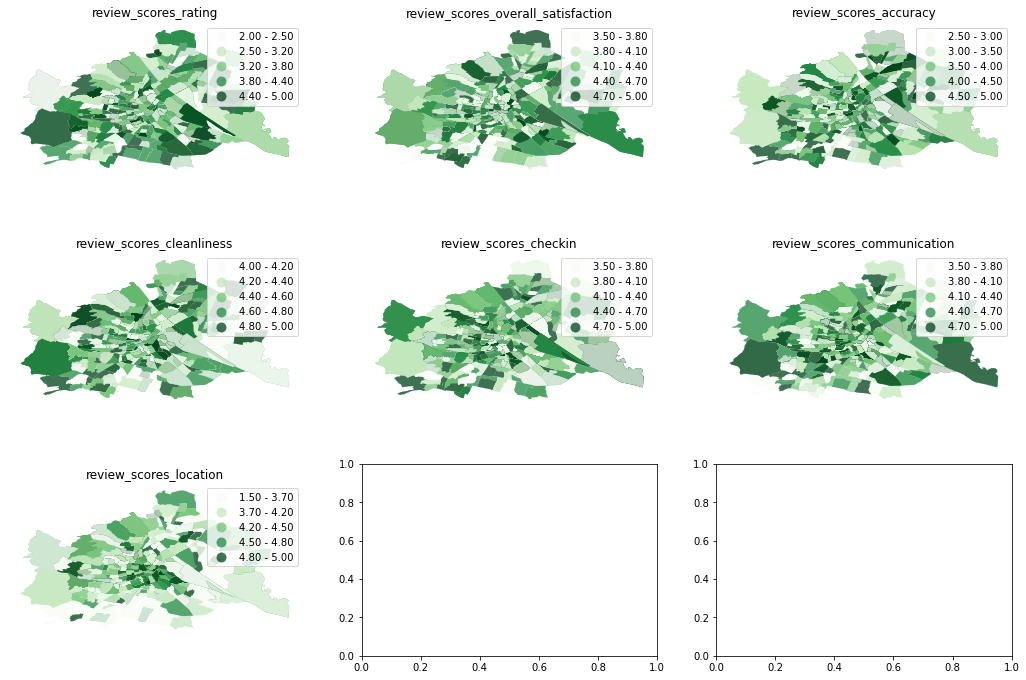

In [49]:
#Plotting all review values
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
# Create figure and axes (this time it's 9, arranged 3 by 3) f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
        # Start the loop over all the variables of interest
for i, col in enumerate(ratings):
# select the axis where the map will go
    ax = axs[i]
# Plot the map
    airbnb_neighb_gdf.plot(column=col, ax=ax, legend=True,scheme='Quantiles', \
    linewidth=0, cmap='Greens', alpha=0.75) # Remove axis clutter
    ax.set_axis_off()
# Set the axis title to the name of variable being plotted 
    ax.set_title(col)
        # Display the figure
plt.show()

In [82]:
#Creating a K-means cluster for analysing the ratings
kmeans5 = cluster.KMeans(n_clusters=5)

In [83]:
kmeans5

KMeans(n_clusters=5)

In [84]:
#Creating K-means cluster for all ratings
k5cls = kmeans5.fit(airbnb_neighb_gdf[ratings])

In [85]:
#Showing the labels
k5cls.labels_

array([0, 3, 2, ..., 0, 4, 1], dtype=int32)

In [86]:
airbnb_neighb_gdf['k5cls'] = k5cls.labels_

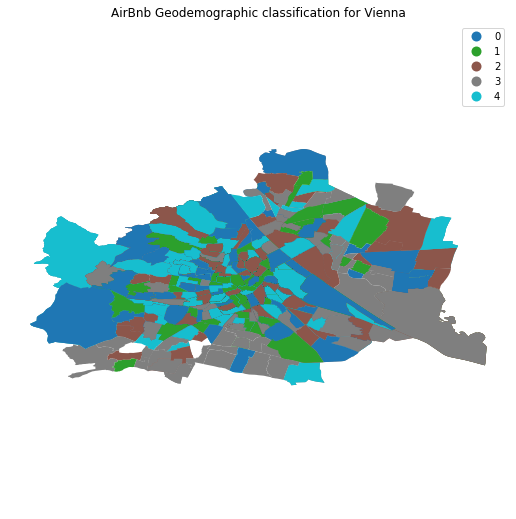

In [90]:
#Plotting the Vienna Map with the k-mean clusters
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
airbnb_neighb_gdf.plot(column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax)

# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('AirBnb Geodemographic classification for Vienna')
# Display the map
plt.show()

In [92]:
#Showing the culster size
k5sizes = airbnb_neighb_gdf.groupby('k5cls').size()
k5sizes

k5cls
0    1193
1    1150
2    1211
3     582
4    1206
dtype: int64

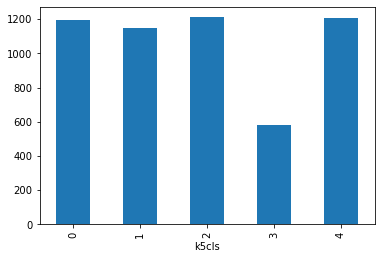

In [93]:
#creating a bar plot for all clusters
_ = k5sizes.plot.bar()

In [114]:
#Creating the ratings mean for all culsters 
k5means = airbnb_neighb_gdf.groupby('k5cls')[ratings].mean()
# Show the table transposed (so it's not too wide)
k5means.T

k5cls,0,1,2,3,4
review_scores_rating,4.252054,4.298783,2.672337,3.735567,2.657877
review_scores_overall_satisfaction,4.268148,4.243217,4.252601,4.199313,4.277363
review_scores_accuracy,3.060520,4.390609,4.427250,3.920790,3.097264
review_scores_cleanliness,4.494384,4.490435,4.483402,4.502062,4.507463
review_scores_checkin,4.228919,4.287130,4.258299,4.285052,4.241128
review_scores_communication,4.237217,4.294261,4.272915,4.237285,4.261774
review_scores_location,4.332858,4.442870,4.349216,2.924742,4.295274


In [115]:
 # Calculate the summary by group
k5desc = airbnb_neighb_gdf.groupby('k5cls')[ratings].describe()
# Show the table
k5desc

review_scores_rating                                                \
                     count      mean       std  min  25%   50%  75%  max   
k5cls                                                                      
0                   1193.0  4.252054  0.458621  3.5  3.9  4.30  4.6  5.0   
1                   1150.0  4.298783  0.446978  3.5  3.9  4.30  4.7  5.0   
2                   1211.0  2.672337  0.438841  2.0  2.3  2.70  3.1  3.5   
3                    582.0  3.735567  0.691818  2.0  3.3  3.75  4.3  5.0   
4                   1206.0  2.657877  0.431575  2.0  2.3  2.60  3.0  3.4   

      review_scores_overall_satisfaction            ...  \
                                   count      mean  ...   
k5cls                                               ...   
0                                 1193.0  4.268148  ...   
1                                 1150.0  4.243217  ...   
2                                 1211.0  4.252601  ...   
3                                  582.0  4.199313  ...   
4                                 1206.0  4.277363  ...   

      review_scores_communication      review_scores_location            \
                              75%  max                  count      mean   
k5cls                                                                     
0                             4.6  5.0                 1193.0  4.332858   
1                             4.7  5.0                 1150.0  4.442870   
2                             4.7  5.0                 1211.0  4.349216   
3                             4.6  5.0                  582.0  2.924742   
4                             4.7  5.0                 1206.0  4.295274   

                                          
            std  min  25%  50%  75%  max  
k5cls                                     
0      0.457884  2.7  4.0  4.4  4.7  5.0  
1      0.398295  3.1  4.1  4.5  4.8  5.0  
2      0.466308  2.9  4.1  4.4  4.7  5.0  
3      0.569602  1.5  2.6  3.1  3.3  3.9  
4      0.505113  2.6  4.0  4.4  4.7  5.0  

[5 rows x 56 columns]

In [121]:
 # Name (index) the rows after the category they belong
to_plot = airbnb_neighb_gdf.set_index('k5cls')
# Subset to keep only variables used in K-means clustering
to_plot = to_plot[ratings]
# Display top of the table
to_plot

,review_scores_rating,review_scores_overall_satisfaction,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location
k5cls,,,,,,,
0,4.6,5.0,2.7,4.7,4.6,3.8,3.9
3,4.1,3.5,4.6,4.0,4.1,3.8,2.5
2,3.4,4.4,4.8,4.9,3.9,3.6,4.9
3,4.3,3.8,4.8,4.7,3.9,3.5,2.7
0,4.4,4.9,2.5,4.4,3.6,4.0,4.8
...,...,...,...,...,...,...,...
3,2.8,4.3,4.5,4.3,4.7,3.6,3.0
0,4.3,4.0,2.5,4.6,5.0,5.0,4.9
0,4.1,4.5,3.6,4.2,3.9,4.1,4.1


In [122]:
#tidy up the table into more useful dataframe
to_plot = to_plot.stack()
to_plot

k5cls                                    
0      review_scores_rating                  4.6
       review_scores_overall_satisfaction    5.0
       review_scores_accuracy                2.7
       review_scores_cleanliness             4.7
       review_scores_checkin                 4.6
                                            ... 
1      review_scores_accuracy                4.7
       review_scores_cleanliness             4.6
       review_scores_checkin                 4.2
       review_scores_communication           4.6
       review_scores_location                4.4
Length: 37394, dtype: float64

In [123]:
# reindexing the table
to_plot = to_plot.reset_index()
to_plot.head()

,k5cls,level_1,0
0,0,review_scores_rating,4.6
1,0,review_scores_overall_satisfaction,5.0
2,0,review_scores_accuracy,2.7
3,0,review_scores_cleanliness,4.7
4,0,review_scores_checkin,4.6


In [124]:
#Renaming the columns of the reidexed table
to_plot = to_plot.rename(columns={'level_1': 'Rating', 0: 'Values'})
to_plot.head()

,k5cls,Rating,Values
0,0,review_scores_rating,4.6
1,0,review_scores_overall_satisfaction,5.0
2,0,review_scores_accuracy,2.7
3,0,review_scores_cleanliness,4.7
4,0,review_scores_checkin,4.6
